In [51]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import shap

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [52]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 27) (14680,) (1840, 27) (1840,)
Index(['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
       'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation',
       'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation',
       'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure',
       'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth',
       'event'],
      dtype='object')


# Random Forest

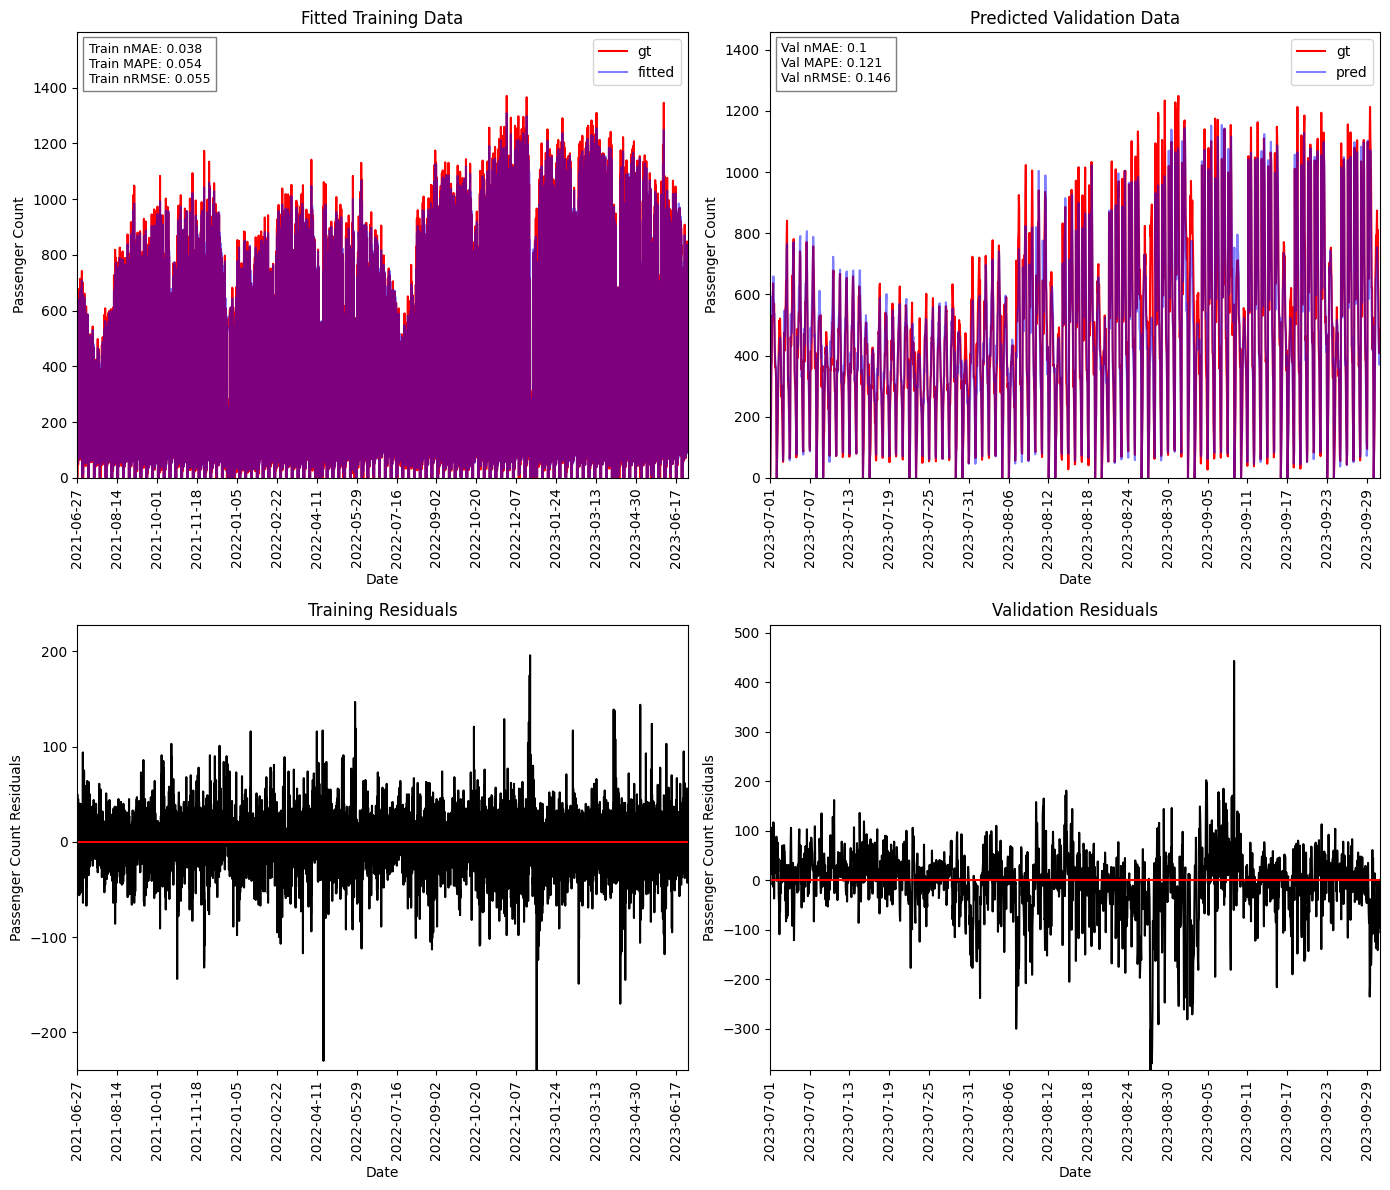

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForestRegressor(n_estimators=250, random_state=42)


In [4]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20, 40, 60, 80, 100, 120, 140]
differentiation = None
n_estimators = 250

# best 60 min with diff
#lags = [20, 40, 60, 80, 100, 120, 140]
#differentiation = 1
#n_estimators = 250


#model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower=None, y_val_upper=None,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

print(model.get_params())
print(model)

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
#                                  y_train_true=y_train, y_val_true=y_val,
#                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
#                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

## Grid search

In [3]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()
#iterator = 0

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for max_depth in [None]:#[10, 20, 30, 50, 75, 100]:
                            for min_sample_split in [2]:#[2, 5, 10]:
                                for min_sample_leaf in [1]:#[1, 2, 4]:
                                    for lags in laglist:
                                        #iterator += 1
                                        #print(iterator)
                                        model = RandomForestRegressor(
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_split=min_sample_split,
                                            min_samples_leaf=min_sample_leaf,
                                            random_state=42)
                                        model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                            differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                            horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                            X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                        
                                        trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                                        valMAE = nMAE(y=y_val, yhat=y_val_pred)
                                        if valMAE < bestMAE:
                                            bestMAE = valMAE
                                            best_model = model
                                            best_lags = lags
                                            best_y_train_pred = y_train_pred
                                            best_y_val_pred = y_val_pred
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    print('')
                    print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    print(model, f'Lags:{best_lags}')
                    print(trainMAE, trainMAPE, trainRMSE)
                    print(valMAE, valMAPE, valRMSE)


fixed Lags:False Drop cal:True drop Weather:False Diff:1
RandomForestRegressor(n_estimators=250, random_state=42) Lags:None
0.249 0.435 0.324
0.729 1.436 0.938

fixed Lags:False Drop cal:True drop Weather:False Diff:None
RandomForestRegressor(n_estimators=250, random_state=42) Lags:None
0.128 0.325 0.17
0.423 1.415 0.548

fixed Lags:False Drop cal:False drop Weather:True Diff:1
RandomForestRegressor(n_estimators=250, random_state=42) Lags:None
0.598 0.958 0.783
0.558 1.321 0.733

fixed Lags:False Drop cal:False drop Weather:True Diff:None
RandomForestRegressor(n_estimators=250, random_state=42) Lags:None
0.339 0.902 0.417
0.351 1.171 0.434

fixed Lags:False Drop cal:False drop Weather:False Diff:1
RandomForestRegressor(n_estimators=250, random_state=42) Lags:None
0.236 0.393 0.317
0.648 1.182 0.848

fixed Lags:False Drop cal:False drop Weather:False Diff:None
RandomForestRegressor(n_estimators=250, random_state=42) Lags:None
0.086 0.201 0.115
0.295 0.59 0.389

fixed Lags:True Drop cal

1A 60min:

Diff=None

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 250      & None\\
\hline
F-RF-C   & 250      & None\\
\hline
F-RF-CW  & 250      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 250      & None\\
\hline
F-RF-C   & 250      & None\\
\hline
F-RF-CW  & 250      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 250      & [1, 4, 8, 20, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# XGBoost

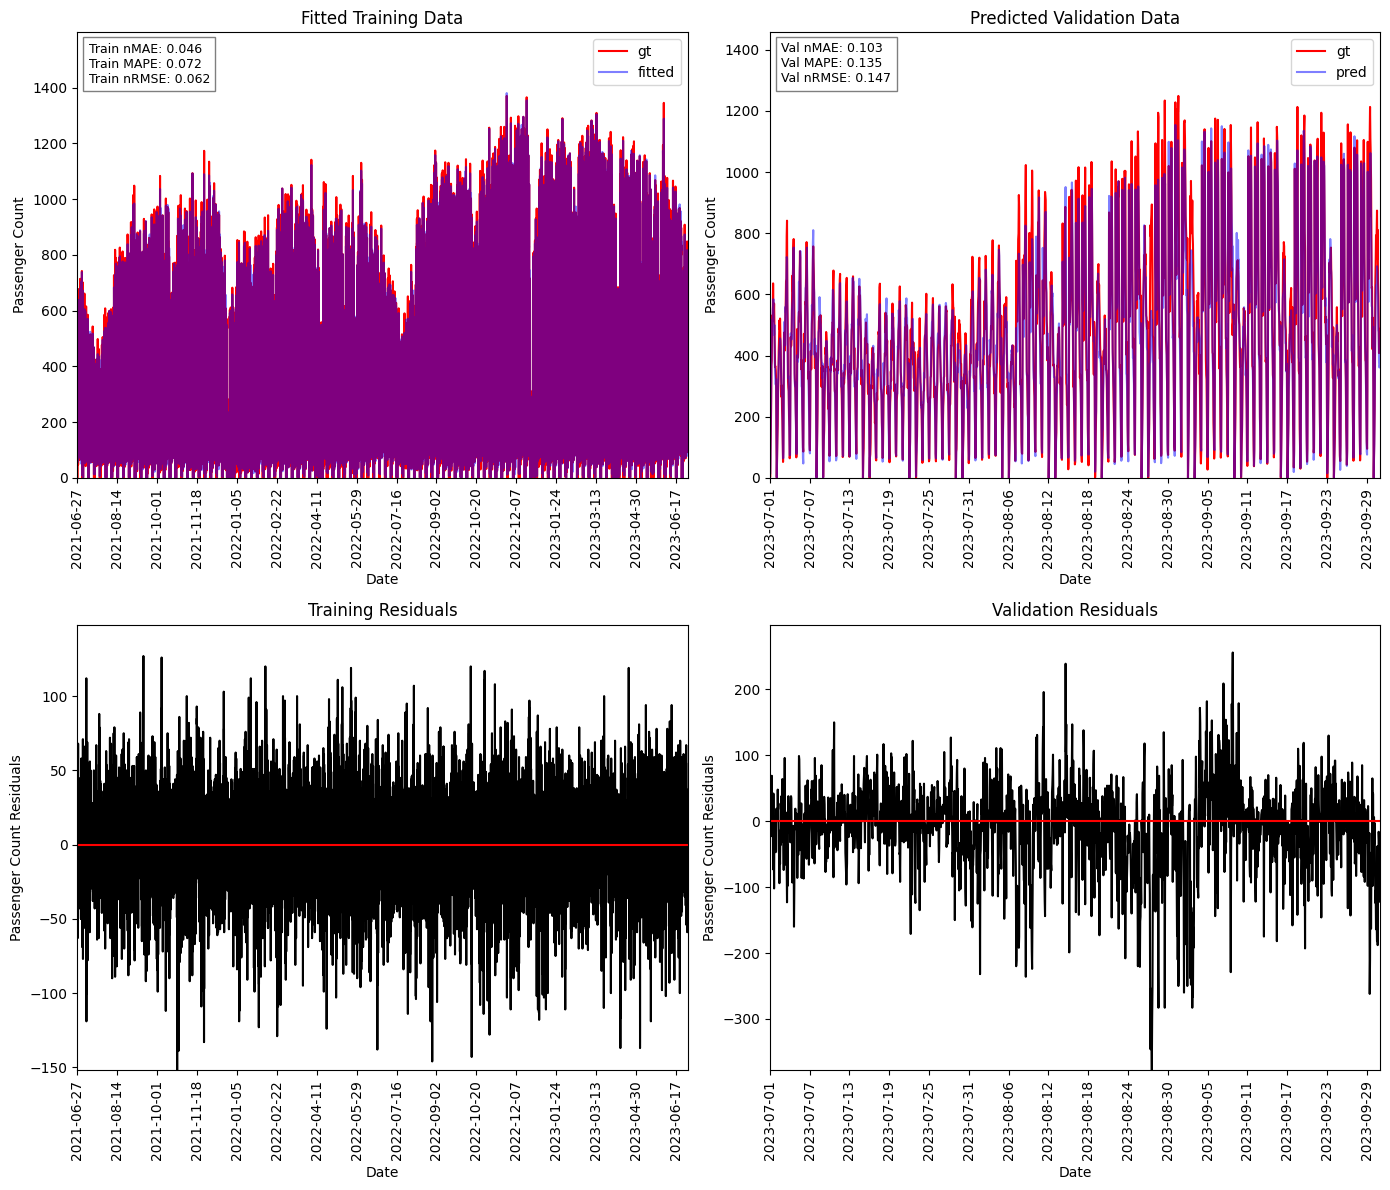

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'alpha': 0.2, 'eta': 0.2, 'seed': 42}
XGBRegressor(alpha=0.2, base_score=None, booster=None, callbac

In [50]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff


# best 60 min with diff


differentiation = None
lags = [20, 40, 60, 80, 100, 120, 140]
model = XGBRegressor(n_estimators=250, alpha=0.2, eta=0.2, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower=None, y_val_upper=None,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

print(model.get_params())
print(model)

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
#                                  y_train_true=y_train, y_val_true=y_val,
#                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
#                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

## Grid search

In [54]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for alpha in [0.0, 0.1, 0.2, 0.3, 0.5]:
                            for eta in [0.01, 0.05, 0.1, 0.2, 0.3]: #[]:
                                for lags in laglist:
                                    model = XGBRegressor(n_estimators=n_estimators, 
                                                         eta=eta,
                                                         alpha=alpha, 
                                                         seed=42)
                                    model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                        differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                        horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                        X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                    
                                    trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                                    valMAE = nMAE(y=y_val, yhat=y_val_pred)
                                    if valMAE < bestMAE:
                                        bestMAE = valMAE
                                        best_model = model
                                        best_y_train_pred = y_train_pred
                                        best_y_val_pred = y_val_pred
                                        best_n_estimator = n_estimators
                                        best_alpha = alpha
                                        best_eta = eta
                                        best_lags = lags
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model.get_xgb_params(), f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}, alpha L1: {best_alpha}, eta: {best_eta}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

# Recursive with feature importance

Docs https://skforecast.org/0.11.0/user_guides/autoregresive-forecaster.html

Example https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

SHAP https://skforecast.org/0.11.0/user_guides/explainability.html

In [70]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

PermutationExplainer explainer: 14681it [06:43, 35.48it/s]                           


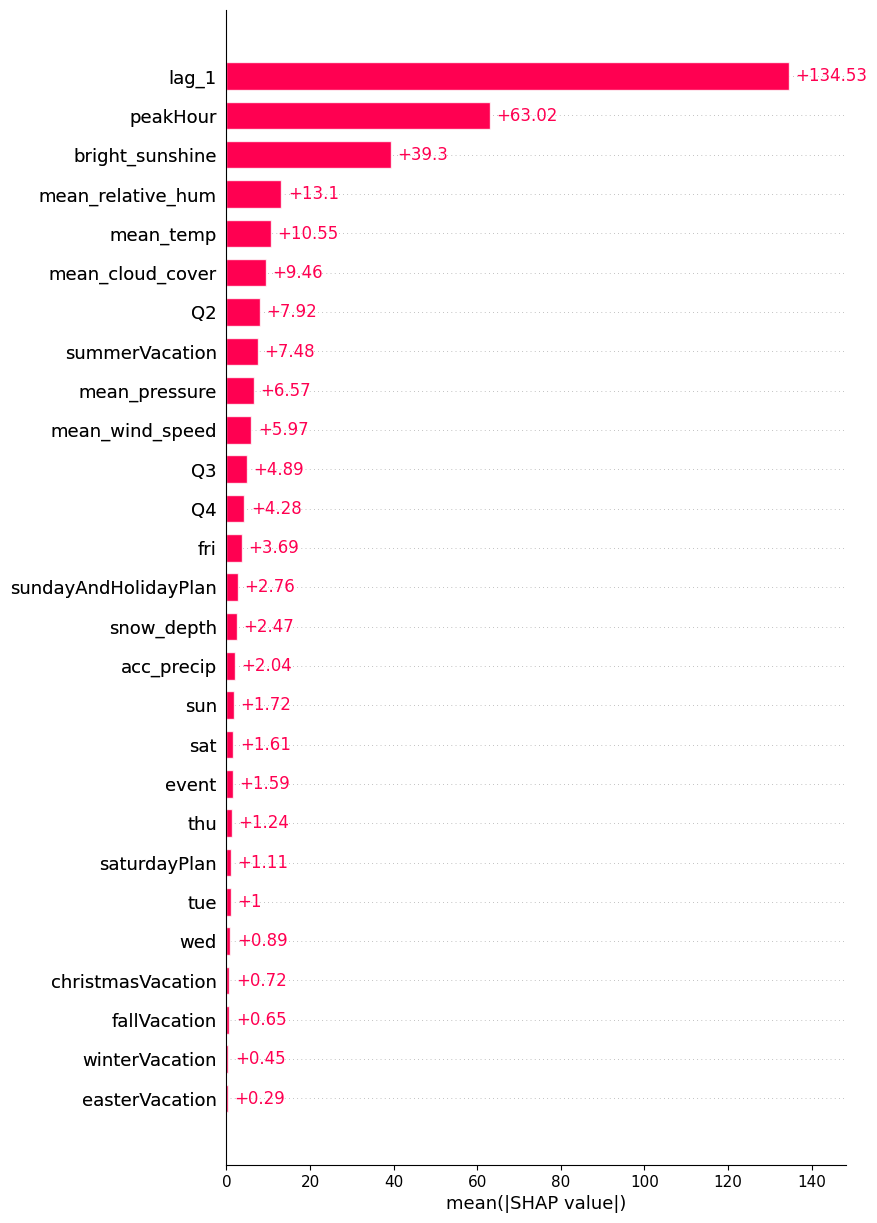

In [71]:
shap.plots.bar(shap_values, max_display=52)

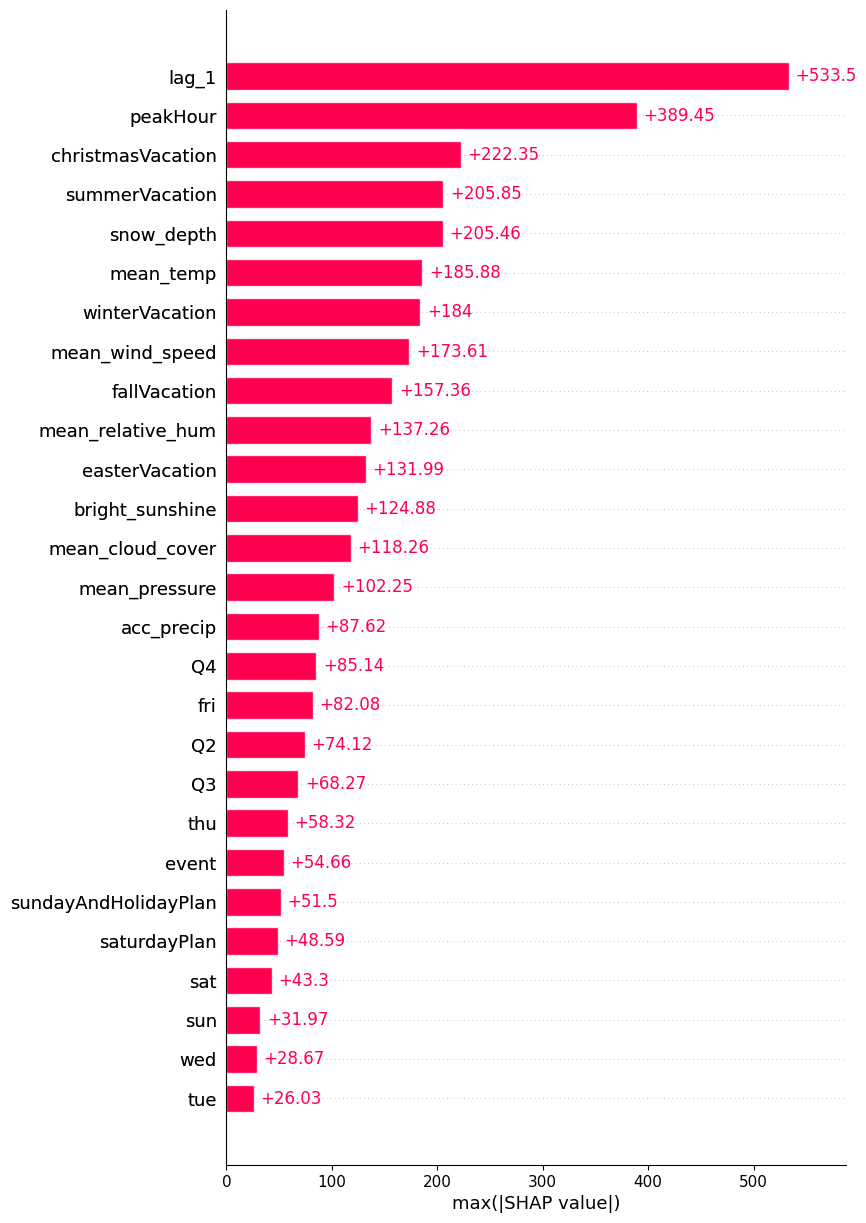

In [72]:
shap.plots.bar(shap_values.abs.max(0), max_display=52)

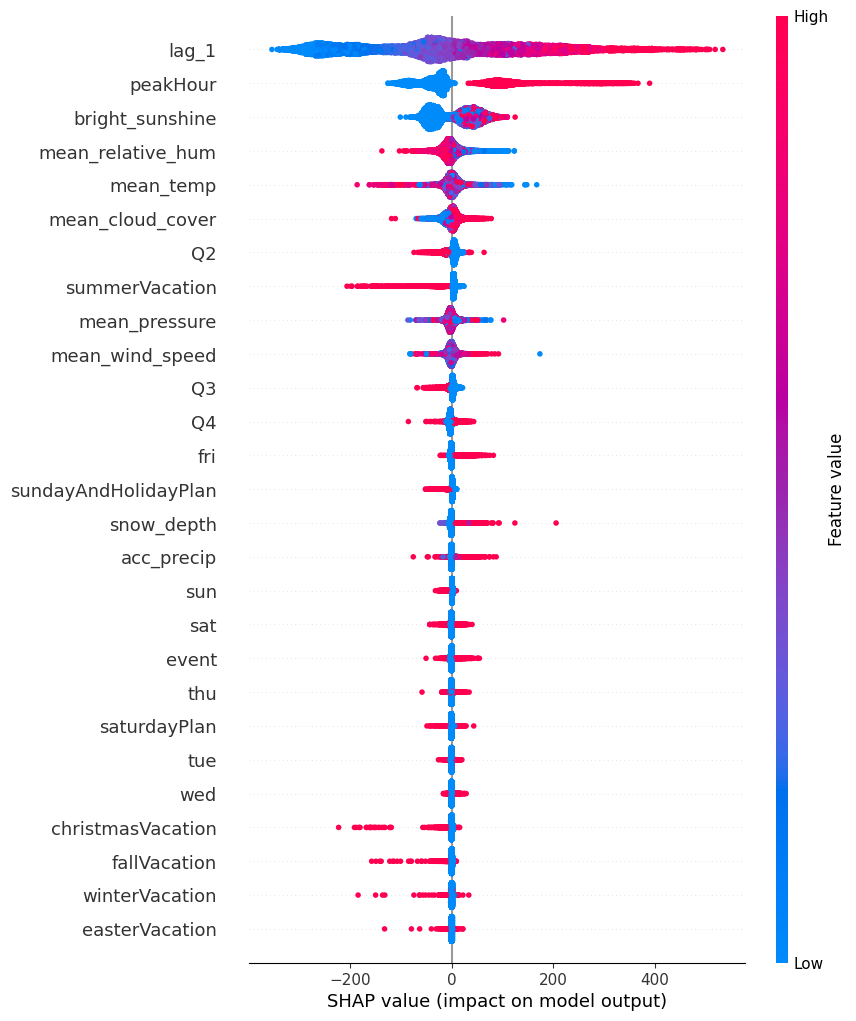

In [73]:
shap.plots.beeswarm(shap_values, max_display=52)

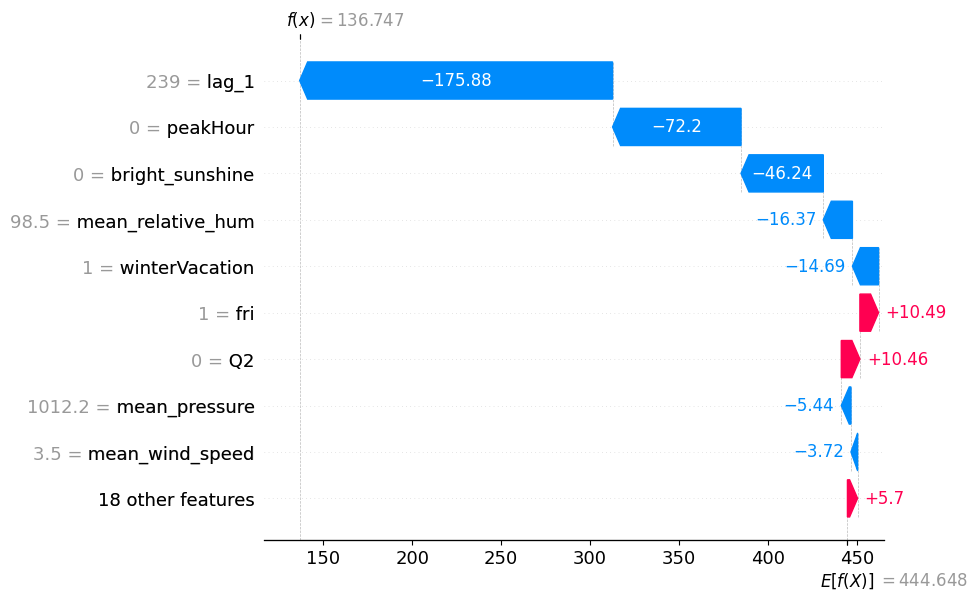

In [84]:
shap.plots.waterfall(shap_values[12000])

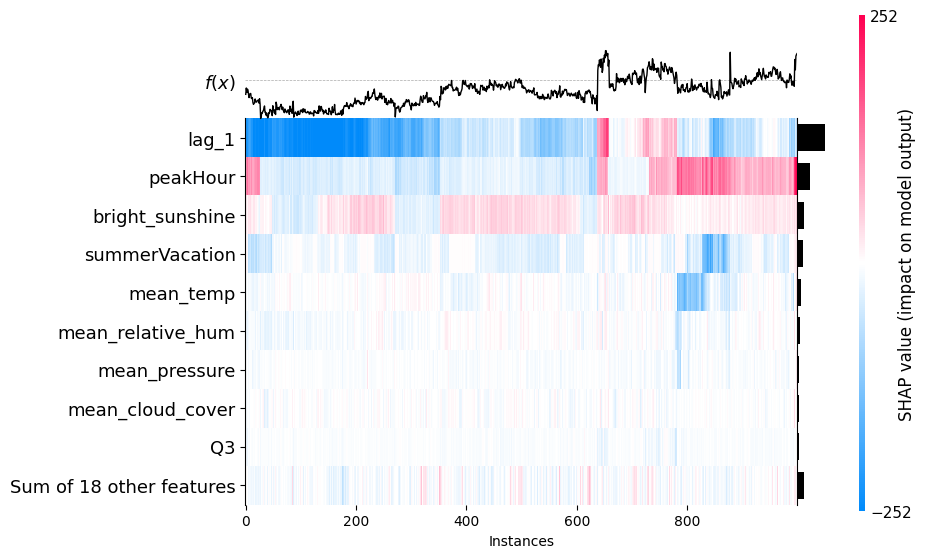

In [74]:
shap.plots.heatmap(shap_values[:1000])

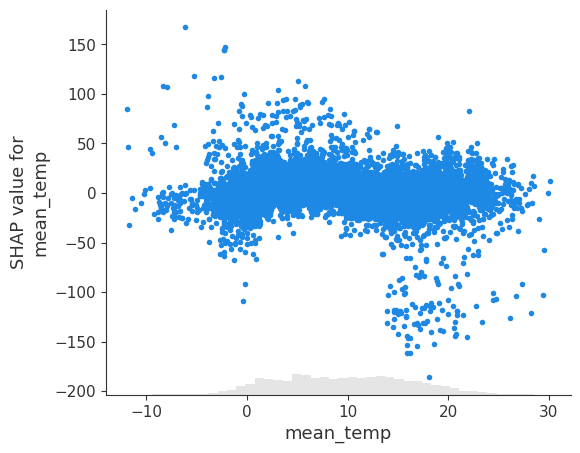

In [75]:
shap.plots.scatter(shap_values[:, 'mean_temp'])

In [86]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train, y_train, n_repeats=30, random_state=42)

# Recursive forecasting

In [11]:
df60 = utils.DataSplitter.getTrainData(60, diff=True)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = utils.DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

if torch.cuda.is_available():
    device = torch.device('cuda')
#elif torch.backends.mps.is_available():
#    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


c:\Users\Andre\OneDrive\Dokumenter\GitHub\Machine-Learning-Passenger-Forecasting\utils\Sklearn.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val_pred = pd.Series()


Execution time: 0.732 sec
train MAE%: 0.265
train MAPE: 0.438
train RMSE%: 0.362
val MAE%: 0.316
val MAPE: 0.631
val RMSE%: 0.416


c:\Users\Andre\OneDrive\Dokumenter\GitHub\Machine-Learning-Passenger-Forecasting\utils\tools.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series()


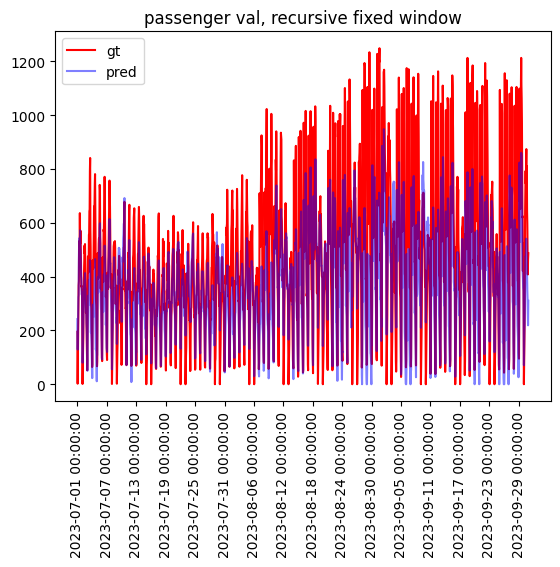

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

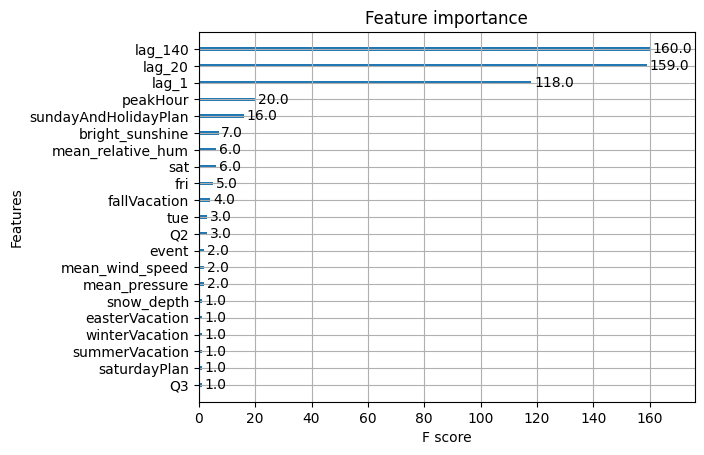

In [12]:
# fixed window forecast (no reestimation)
horizon = 40
lags = [1, 20, 140]
diff = 1

model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.Sklearn.fixedWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive fixed window')
plt.legend()
plt.show()

xgb.plot_importance(model)

c:\Users\Andre\OneDrive\Dokumenter\GitHub\Machine-Learning-Passenger-Forecasting\utils\Sklearn.py:154: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val_pred = pd.Series()


RangeIndex(start=0, stop=14680, step=1)
RangeIndex(start=0, stop=14720, step=1)
RangeIndex(start=0, stop=14760, step=1)
RangeIndex(start=0, stop=14800, step=1)
RangeIndex(start=0, stop=14840, step=1)
RangeIndex(start=0, stop=14880, step=1)
RangeIndex(start=0, stop=14920, step=1)
RangeIndex(start=0, stop=14960, step=1)
RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=15040, step=1)
RangeIndex(start=0, stop=15080, step=1)
RangeIndex(start=0, stop=15120, step=1)
RangeIndex(start=0, stop=15160, step=1)
RangeIndex(start=0, stop=15200, step=1)
RangeIndex(start=0, stop=15240, step=1)
RangeIndex(start=0, stop=15280, step=1)
RangeIndex(start=0, stop=15320, step=1)
RangeIndex(start=0, stop=15360, step=1)
RangeIndex(start=0, stop=15400, step=1)
RangeIndex(start=0, stop=15440, step=1)
RangeIndex(start=0, stop=15480, step=1)
RangeIndex(start=0, stop=15520, step=1)
RangeIndex(start=0, stop=15560, step=1)
RangeIndex(start=0, stop=15600, step=1)
RangeIndex(start=0, stop=15640, step=1)


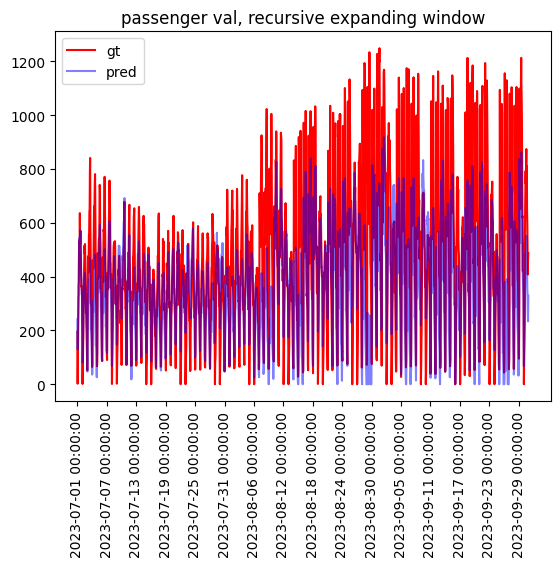

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

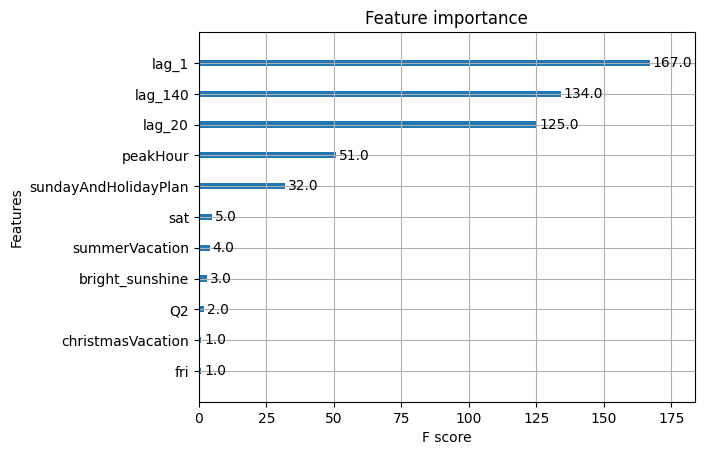

In [13]:
# expanding window forecast (reestimation)
horizon = 40
lags = [1, 20, 140]
diff = 1

model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.Sklearn.expandingWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive expanding window')
plt.legend()
plt.show()

xgb.plot_importance(model)

c:\Users\Andre\OneDrive\Dokumenter\GitHub\Machine-Learning-Passenger-Forecasting\utils\Sklearn.py:212: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val_pred = pd.Series()


RangeIndex(start=7400, stop=14680, step=1)
RangeIndex(start=7440, stop=14720, step=1)
RangeIndex(start=7480, stop=14760, step=1)
RangeIndex(start=7520, stop=14800, step=1)
RangeIndex(start=7560, stop=14840, step=1)
RangeIndex(start=7600, stop=14880, step=1)
RangeIndex(start=7640, stop=14920, step=1)
RangeIndex(start=7680, stop=14960, step=1)
RangeIndex(start=7720, stop=15000, step=1)
RangeIndex(start=7760, stop=15040, step=1)
RangeIndex(start=7800, stop=15080, step=1)
RangeIndex(start=7840, stop=15120, step=1)
RangeIndex(start=7880, stop=15160, step=1)
RangeIndex(start=7920, stop=15200, step=1)
RangeIndex(start=7960, stop=15240, step=1)
RangeIndex(start=8000, stop=15280, step=1)
RangeIndex(start=8040, stop=15320, step=1)
RangeIndex(start=8080, stop=15360, step=1)
RangeIndex(start=8120, stop=15400, step=1)
RangeIndex(start=8160, stop=15440, step=1)
RangeIndex(start=8200, stop=15480, step=1)
RangeIndex(start=8240, stop=15520, step=1)
RangeIndex(start=8280, stop=15560, step=1)
RangeIndex(

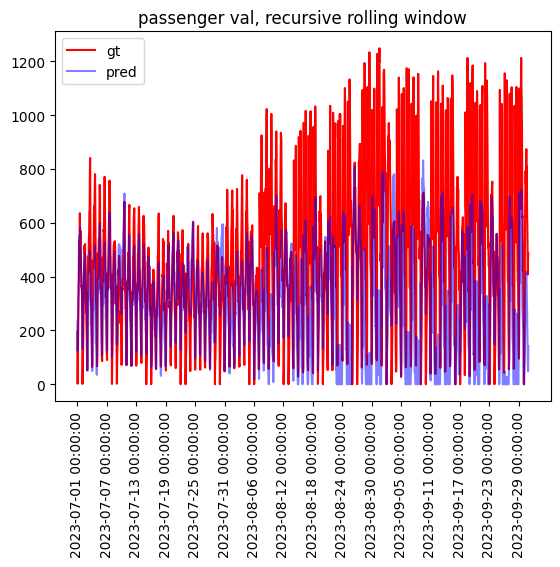

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

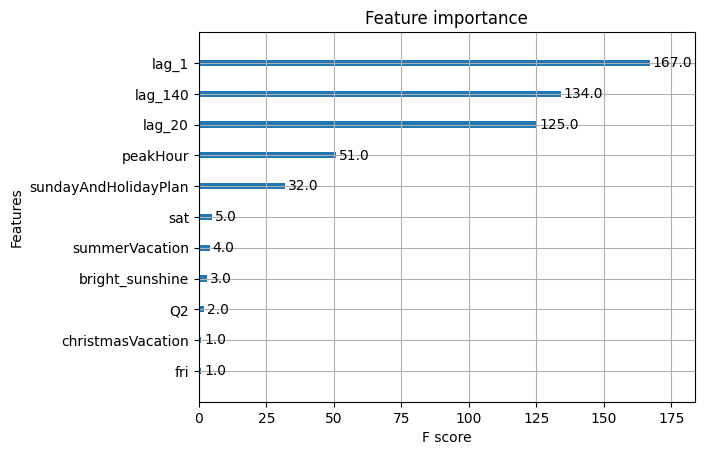

In [15]:
# rolling window forecast (reestimation)
horizon = 40
lags = [1, 20, 140]
diff = 1
model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.Sklearn.rollingWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, 
    differentiation=diff, horizon=horizon, window_size=20*7*52, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive rolling window')
plt.legend()
plt.show()

xgb.plot_importance(model)